In [10]:
# imports
import utils.rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import seaborn as sns
import matplotlib 

In [11]:
# User Variables

ROSBAGS_DIR = "/home/bjm255/cougars/bag" + '/good_bags' 
# ROSBAGS_DIR = "/home/bjm255/couguv/cougars/bag" + '/sim' 
SAVES_DIR = "DFB_Oceans_Paper"

# TODO get the plots to just save to this folder

MISSION_KEYWORDS = ["32.1"]
start_crop = 0
end_crop = -1

sim_crop = 0
end_crop_sim = -1


start_crop = 1124       # Used for 32.1
# start_crop = 1780        # Used for 33.0
end_crop = -2500     # Used for 32.1
# end_crop = -2500 + 500  # Used for 33.0

sim_crop = 0     #used for  32.1
# sim_crop = 1780-1124     #used for 33.0 
end_crop_sim = -270  # Used for 32.1
# end_crop_sim = -1 # Used for 33.0

VERBOSE=True

In [12]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/bjm255/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/converted__sim_32.1.16_20250730_164309
Loading /home/bjm255/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/converted__32.1_bl_dfb_20250723_191538


In [13]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

converted__sim_32.1.16_20250730_164309:
	['/desired_depth', '/modem_imu', '/desired_heading', '/dvl/data', '/diagnostics', '/pressure/data', '/controls/debug', '/controls/command', '/depth_data', '/desired_speed']
converted__32.1_bl_dfb_20250723_191538:
	['/leak/data', '/dvl/dead_reckoning', '/desired_depth', '/modem_imu', '/desired_heading', '/dvl/velocity', '/dvl/position', '/dvl/data', '/diagnostics', '/pressure/data', '/battery/data', '/kinematics/command', '/controls/debug', '/controls/command', '/dvl/dr_global', '/depth_data', '/modem_status', '/desired_speed']


In [14]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
# dfsByTopic = {}

# for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
# print(list(dfsByTopic.keys()))

In [15]:
# Get only the first dataframe
rw_data, rw_topics = list(dataframes.items())[1]


# Get the second dataframe
sim_data, sim_topics = list(dataframes.items())[0]

print(f"Sim Bag: {sim_data}:\n\t{list(sim_topics.keys())}")
print(f"Real World Bag: {rw_data}:\n\t{list(rw_topics.keys())}")

Sim Bag: converted__sim_32.1.16_20250730_164309:
	['/desired_depth', '/modem_imu', '/desired_heading', '/dvl/data', '/diagnostics', '/pressure/data', '/controls/debug', '/controls/command', '/depth_data', '/desired_speed']
Real World Bag: converted__32.1_bl_dfb_20250723_191538:
	['/leak/data', '/dvl/dead_reckoning', '/desired_depth', '/modem_imu', '/desired_heading', '/dvl/velocity', '/dvl/position', '/dvl/data', '/diagnostics', '/pressure/data', '/battery/data', '/kinematics/command', '/controls/debug', '/controls/command', '/dvl/dr_global', '/depth_data', '/modem_status', '/desired_speed']


In [16]:
# Display a dataframe
print(f"DataFrame example:")
sampleDf = rw_topics["/controls/debug"]
print(sampleDf.iloc[:5])
print("...")

DataFrame example:
   header.stamp.sec  header.stamp.nanosec  header.frame_id  depth.actual  \
0        1753319738             824397166              NaN     -0.000895   
1        1753319738             904417626              NaN     -0.001099   
2        1753319738             984409641              NaN     -0.001508   
3        1753319739              64349379              NaN     -0.001099   
4        1753319739             144414450              NaN     -0.001201   

   depth.rate  depth.desired  depth.reference   depth.p  depth.i  depth.d  \
0         0.0            0.0     2.246924e-16  0.017893      0.0      0.0   
1         0.0            0.0     2.193639e-16  0.021982      0.0      0.0   
2         0.0            0.0     2.141619e-16  0.030162      0.0      0.0   
3         0.0            0.0     2.090832e-16  0.021982      0.0      0.0   
4         0.0            0.0     2.041249e-16  0.024027      0.0      0.0   

   ...   pitch.d  pitch.pid  heading.actual  heading.rate  he

In [17]:
# convert ros timestamps to pandas timestamps

for df in sim_topics.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

sim_timestamps = sim_topics["/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{sim_timestamps.min()} --- {sim_timestamps.max()}")

for df in rw_topics.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

rw_timestamps = rw_topics["/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{rw_timestamps.min()} --- {rw_timestamps.max()}")

RosBag timeframe:	2025-07-30 22:43:09.690909081 --- 2025-07-30 22:45:59.691100301
RosBag timeframe:	2025-07-24 01:15:39.294687887 --- 2025-07-24 01:22:59.794713233


/tmp/ipykernel_2140072/2225689763.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()
/tmp/ipykernel_2140072/2225689763.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()


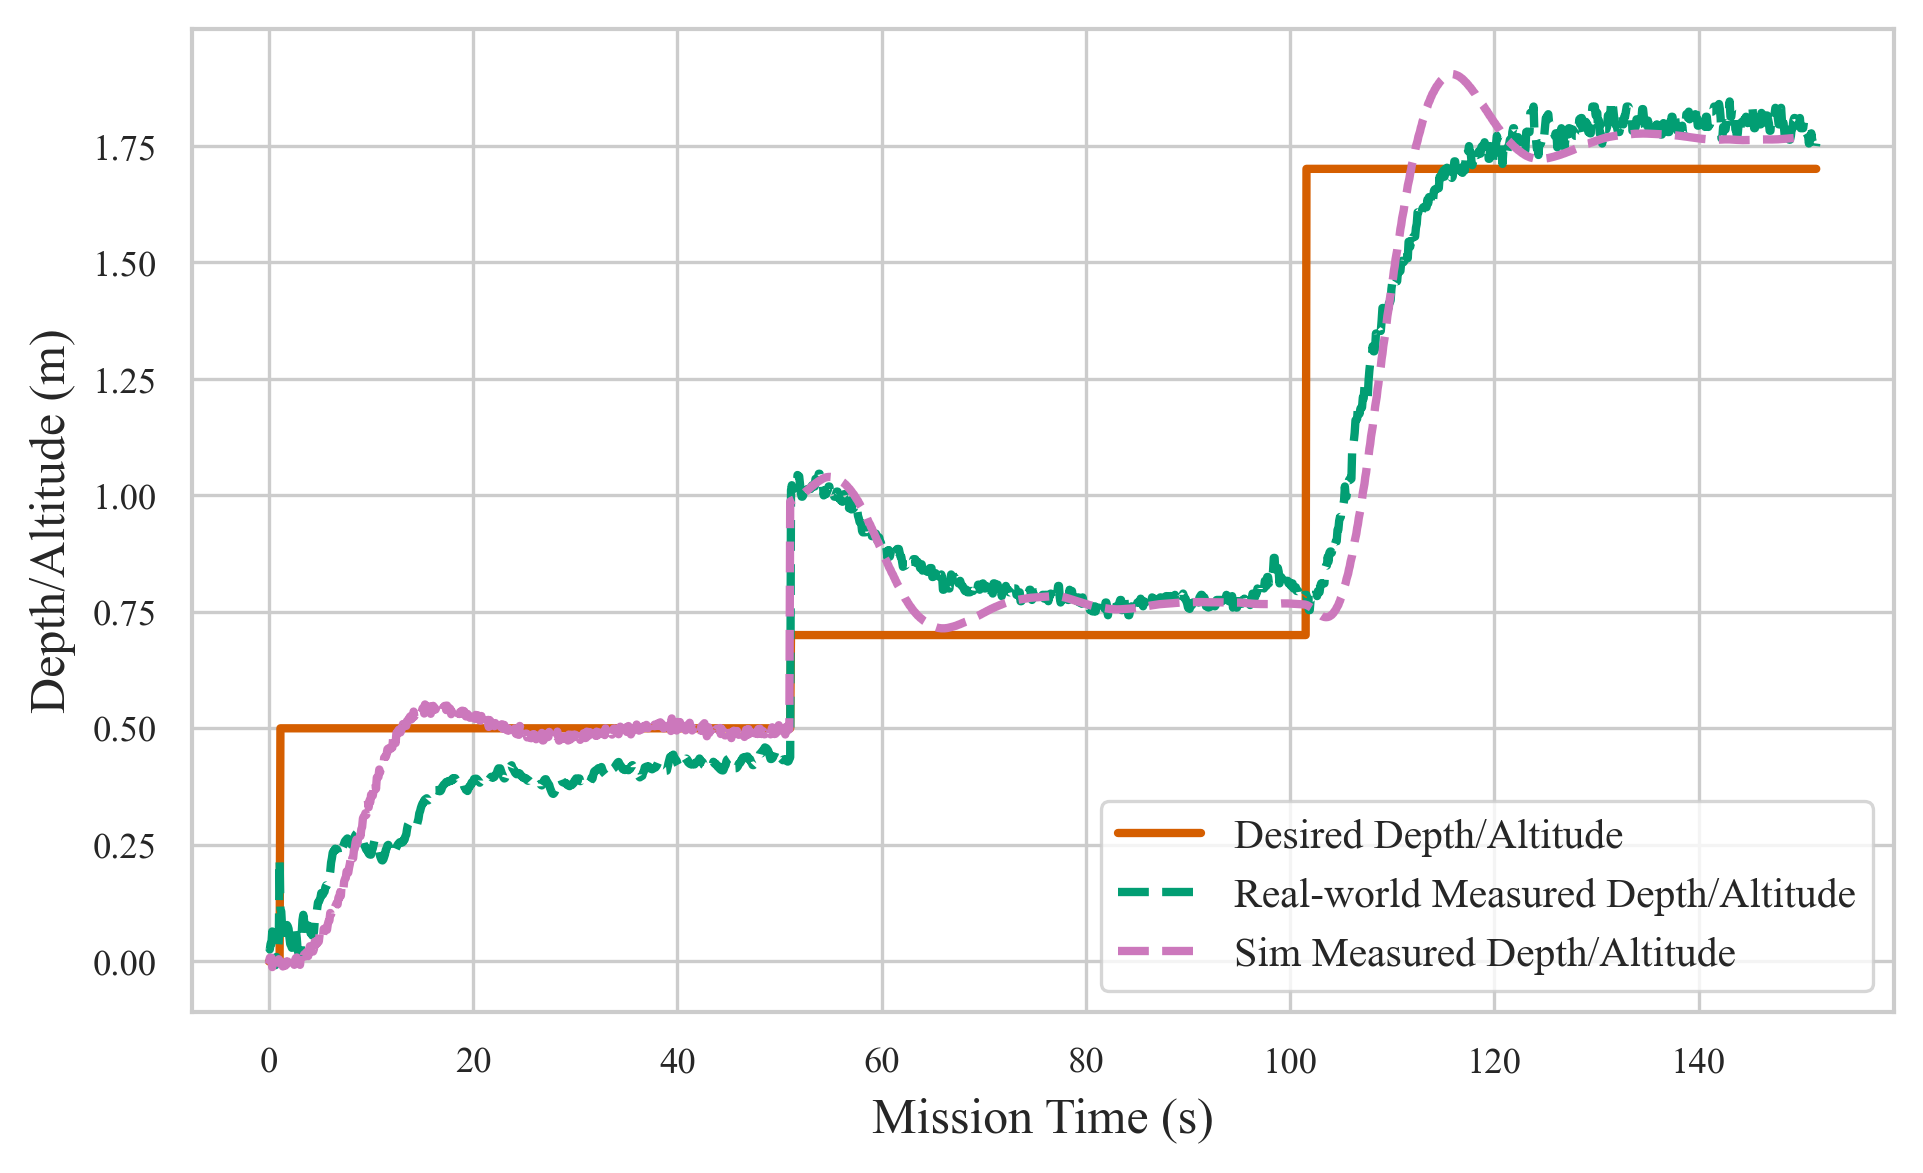

In [18]:
# Apply PDF font embedding and font settings for high-quality vector text in PDF
matplotlib.rc("pdf", fonttype=42)

# Seaborn styles for paper-quality plots
sns.set_context("paper")       # scales fonts nicely for paper
sns.set_style("whitegrid")     # white grid background
sns.set_palette("colorblind")  # colorblind-friendly palette
c = sns.color_palette("colorblind")  # get colorblind palette colors

# Set Times New Roman font and math font style for publication
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"



rw_controls_debug = rw_topics["/controls/debug"]

cropped_rw_df = rw_controls_debug.iloc[start_crop:end_crop]

sim_controls_debug = sim_topics["/controls/debug"]
cropped_sim_df = sim_controls_debug.iloc[sim_crop:end_crop_sim]

# Convert timestamp to seconds since mission start
start_time = cropped_rw_df["timestamp"].iloc[0]
cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_rw_df["time_sec"].to_numpy()
y1 = cropped_rw_df["depth.desired"].to_numpy()
y2 = cropped_rw_df["depth.actual"].to_numpy()


# Convert timestamp to seconds since mission start
start_time = cropped_sim_df["timestamp"].iloc[0]
cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x_sim = cropped_sim_df["time_sec"].to_numpy()
y_sim1 = cropped_sim_df["depth.desired"].to_numpy()
y_sim2 = cropped_sim_df["depth.actual"].to_numpy()

# Plot
# Create figure with high DPI for sharp output
fig, ax = plt.subplots(figsize=(6.5, 4), dpi=300)
# Use seaborn colorblind palette colors by index

ax.plot(x, y1, color=c[3], label='Desired Depth/Altitude', linewidth=2)
ax.plot(x, y2, color=c[2], label='Real-world Measured Depth/Altitude', linewidth=2, linestyle='--')
# # ax.plot(x_sim, y_sim1, label='Depth Sim Desired', color='purple', linewidth=2)

ax.plot(x_sim, y_sim2, label='Sim Measured Depth/Altitude', color=c[4], linewidth=2, linestyle='--')


# # ax.plot(x, y3, label='Depth Reference', color='red', linewidth=2, linestyle='--')

# Labels and formatting
# ax.set_title('Depth Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Depth/Altitude (m)', fontsize=12)
# ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()

# Save figure as PDF with embedded fonts and tight layout
fig.savefig("depth_controls_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [19]:
import yaml

# Get Depth Data
rw_depth_data = rw_topics["/depth_data"]
depth_rw_df = rw_depth_data.copy()

# Get Altitude Data
rw_dvl_data = rw_topics["/dvl/data"]
dvl_rw_df = rw_dvl_data.copy()

# Use the earliest timestamp from both topics as the reference start time
start_time = min(depth_rw_df["timestamp"].iloc[0], dvl_rw_df["timestamp"].iloc[0])

depth_rw_df["time_sec"] = (depth_rw_df["timestamp"] - start_time).dt.total_seconds()
dvl_rw_df["time_sec"] = (dvl_rw_df["timestamp"] - start_time).dt.total_seconds()

# Define cropping range in seconds
crop_start_sec = 90

crop_end_sec = 350  # Crop time for 33.0
crop_end_sec = 240 # Crop time for 32.1

# Crop both dataframes by mission time
depth_rw_df = depth_rw_df[(depth_rw_df["time_sec"] >= crop_start_sec) & (depth_rw_df["time_sec"] <= crop_end_sec)]
dvl_rw_df = dvl_rw_df[(dvl_rw_df["time_sec"] >= crop_start_sec) & (dvl_rw_df["time_sec"] <= crop_end_sec)]

# Extract data
t = depth_rw_df["time_sec"].to_numpy()
depth = depth_rw_df["pose.pose.position.z"].to_numpy() * -1

# Find the closest altitude measurement for each depth timestamp
altitude = []
dvl_time = dvl_rw_df["time_sec"].to_numpy()
dvl_alt = dvl_rw_df["altitude"].to_numpy()

for ts in t:
    closest_idx = np.abs(dvl_time - ts).argmin()
    altitude.append(dvl_alt[closest_idx])

altitude = np.array(altitude)

# Calculate water column depth
water_column_depth = depth + altitude

# Load mission sequence from YAML
with open("mission_" + MISSION_KEYWORDS[0] + ".yaml", "r") as f:
    mission_data = yaml.safe_load(f)

states = mission_data["states"]

# Create desired depth array over cropped time t (initialized to NaN for clarity)
desired_depth = np.full_like(t, np.nan)

current_time = 0.0

for state in states:
    duration = state["time_seconds"]
    depth_val = state["depth"]
    dfb = state.get("depth_from_bottom", False)

    # Determine indices in t that correspond to this state interval
    mask = (t >= current_time) & (t < current_time + duration)
    t_segment = t[mask]

    if len(t_segment) == 0:
        current_time += duration
        continue

    if dfb:
        # dynamic desired depth from bottom for all times in this segment
        # desired depth = water column depth - depth_val
        desired_depth[mask] = water_column_depth[mask] - depth_val
    else:
        # desired depth from surface (constant for the interval)
        desired_depth[mask] = depth_val

    current_time += duration

# Optional: For numerical stability, fill any NaN in desired_depth (e.g., after last state) with last valid value
if np.any(np.isnan(desired_depth)):
    # Forward fill NaNs with previous value or fill with last valid value
    nan_mask = np.isnan(desired_depth)
    not_nan_mask = ~nan_mask
    if np.any(not_nan_mask):
        last_val = desired_depth[not_nan_mask][-1]
        desired_depth[nan_mask] = last_val
    else:
        desired_depth[:] = 0  # fallback if everything is NaN

# Create a zero line for water surface
zeros = np.zeros_like(t)


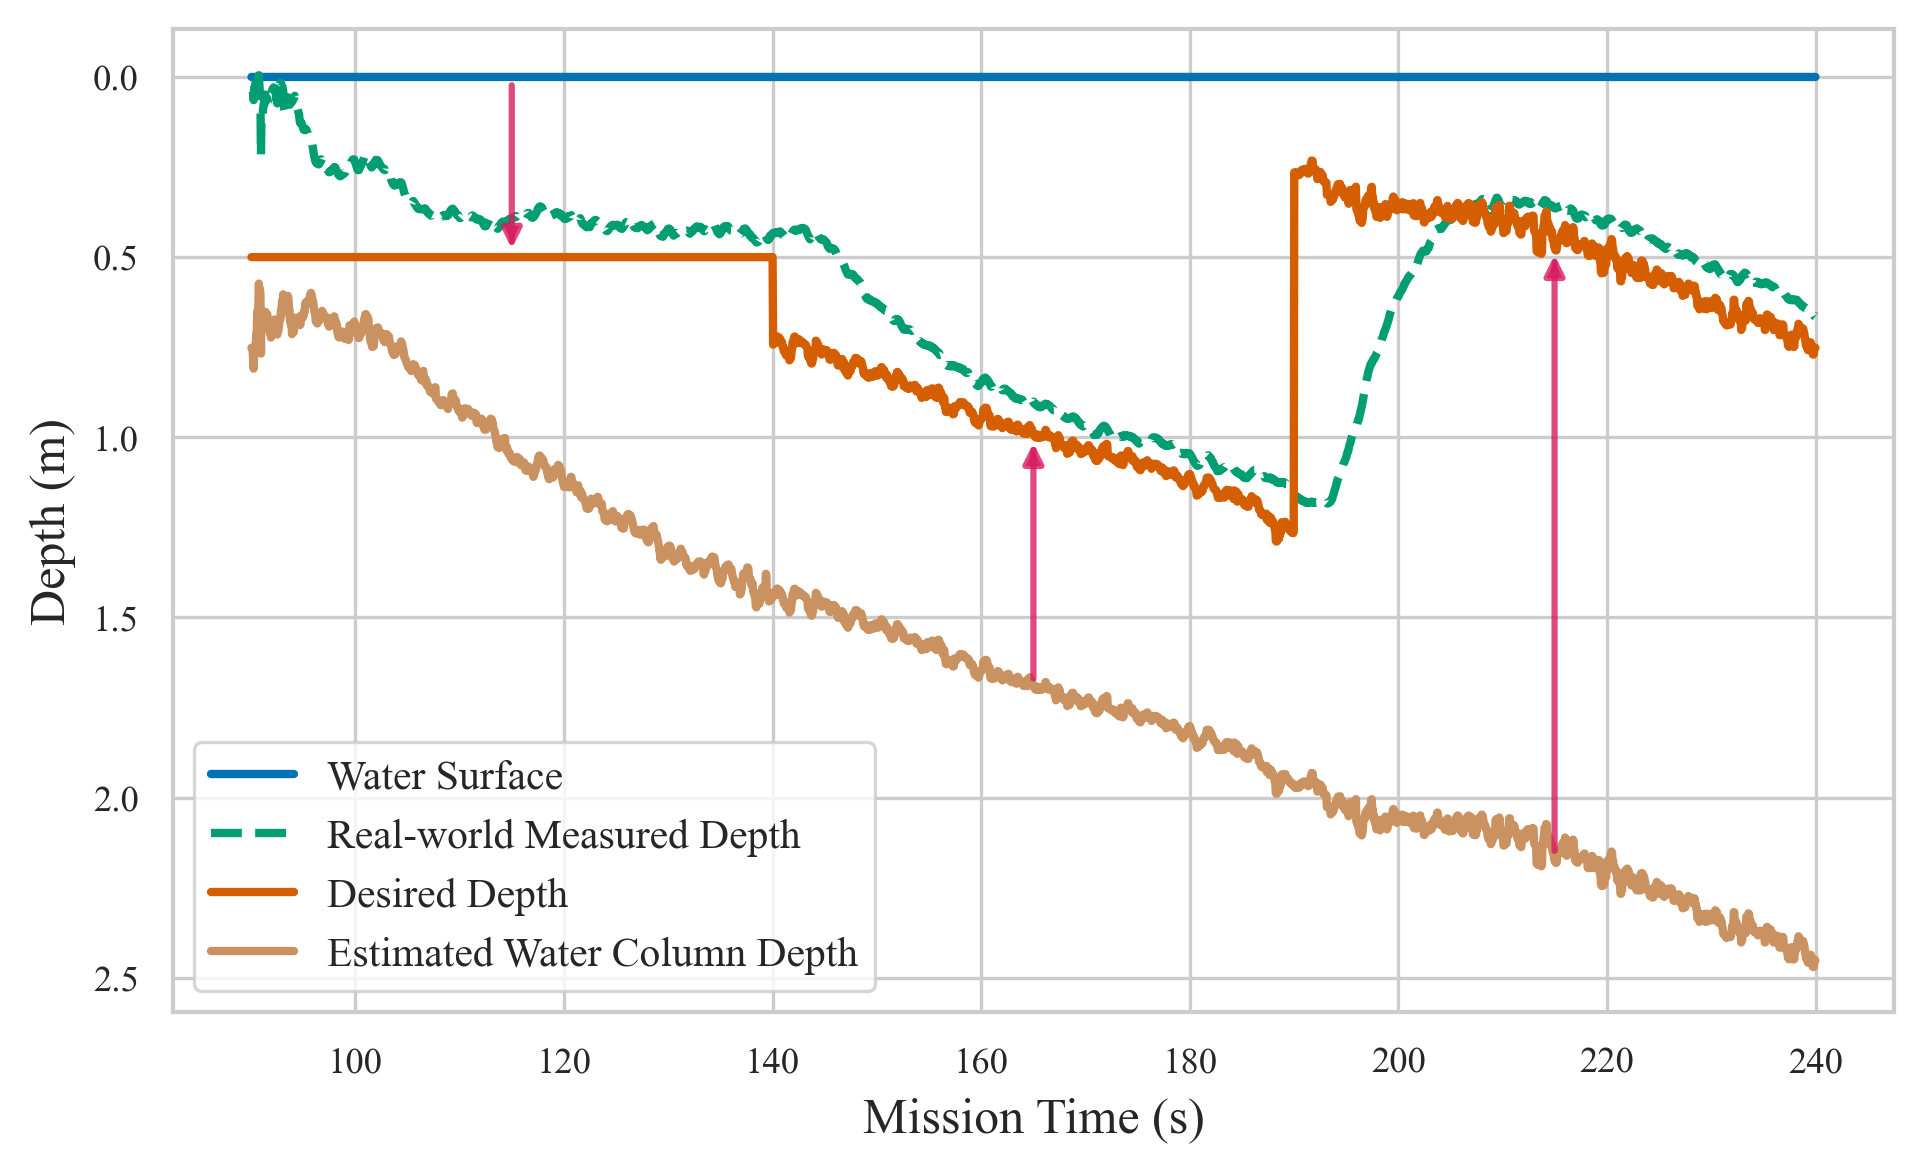

In [20]:
import seaborn as sns
import matplotlib 

# Apply PDF font embedding and font settings for high-quality vector text in PDF
matplotlib.rc("pdf", fonttype=42)

# Seaborn styles for paper-quality plots
sns.set_context("paper")       # scales fonts nicely for paper
sns.set_style("whitegrid")     # white grid background
sns.set_palette("colorblind")  # colorblind-friendly palette
c = sns.color_palette("colorblind")  # get colorblind palette colors

# Set Times New Roman font and math font style for publication
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

# Create figure with high DPI for sharp output
fig, ax = plt.subplots(figsize=(6.5, 4), dpi=300)

# Use seaborn colorblind palette colors by index
ax.plot(t, zeros, label='Water Surface',
        color=c[0], linewidth=2)  # blue color for water surface
ax.plot(t, depth, label='Real-world Measured Depth',
        color=c[2], linewidth=2, linestyle='--')
ax.plot(t, desired_depth, label='Desired Depth',
        color=c[3], linewidth=2)
ax.plot(t, water_column_depth, label='Estimated Water Column Depth',
        color=c[5], linewidth=2)  # c[1] is a nice distinct color

# Labels and formatting
# ax.set_title('Real World', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.invert_yaxis()
ax.legend(loc='lower left', fontsize=10)
# ax.grid(True, linestyle='--', alpha=0.5)

# Assuming current_time has just finished building desired_depth
current_time = 0.0
for state in states:
    duration = state["time_seconds"]
    midpoint = current_time + duration / 2
    idx = np.abs(t - midpoint).argmin()
    x = t[idx]
    y_surface = 0
    y_water_column = water_column_depth[idx]
    y_desired = desired_depth[idx]
    arrow_color = '#D81B60'  # Dark orange/red

    if state.get("depth_from_bottom", False):
        # If depth is from bottom, draw arrow from water column to desired depth
        y_surface = y_water_column
        y_desired = y_water_column - state["depth"]
    else:
        # If depth is from surface, draw arrow from surface to desired depth
        y_surface = 0
        y_desired = state["depth"]


    ax.annotate('', xy=(x, y_desired), xytext=(x, y_surface),
                arrowprops=dict(facecolor=arrow_color, edgecolor=arrow_color, arrowstyle='-|>', lw=1.5, alpha=0.8))
    

    current_time += duration

plt.tight_layout()

# Save figure as PDF with embedded fonts and tight layout
fig.savefig("depth_profile" + MISSION_KEYWORDS[0] + ".pdf", dpi=300, bbox_inches='tight')

plt.show()

Number of samples in cropped sim dataframe: 5519


/tmp/ipykernel_2140072/3998943317.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()
/tmp/ipykernel_2140072/3998943317.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()


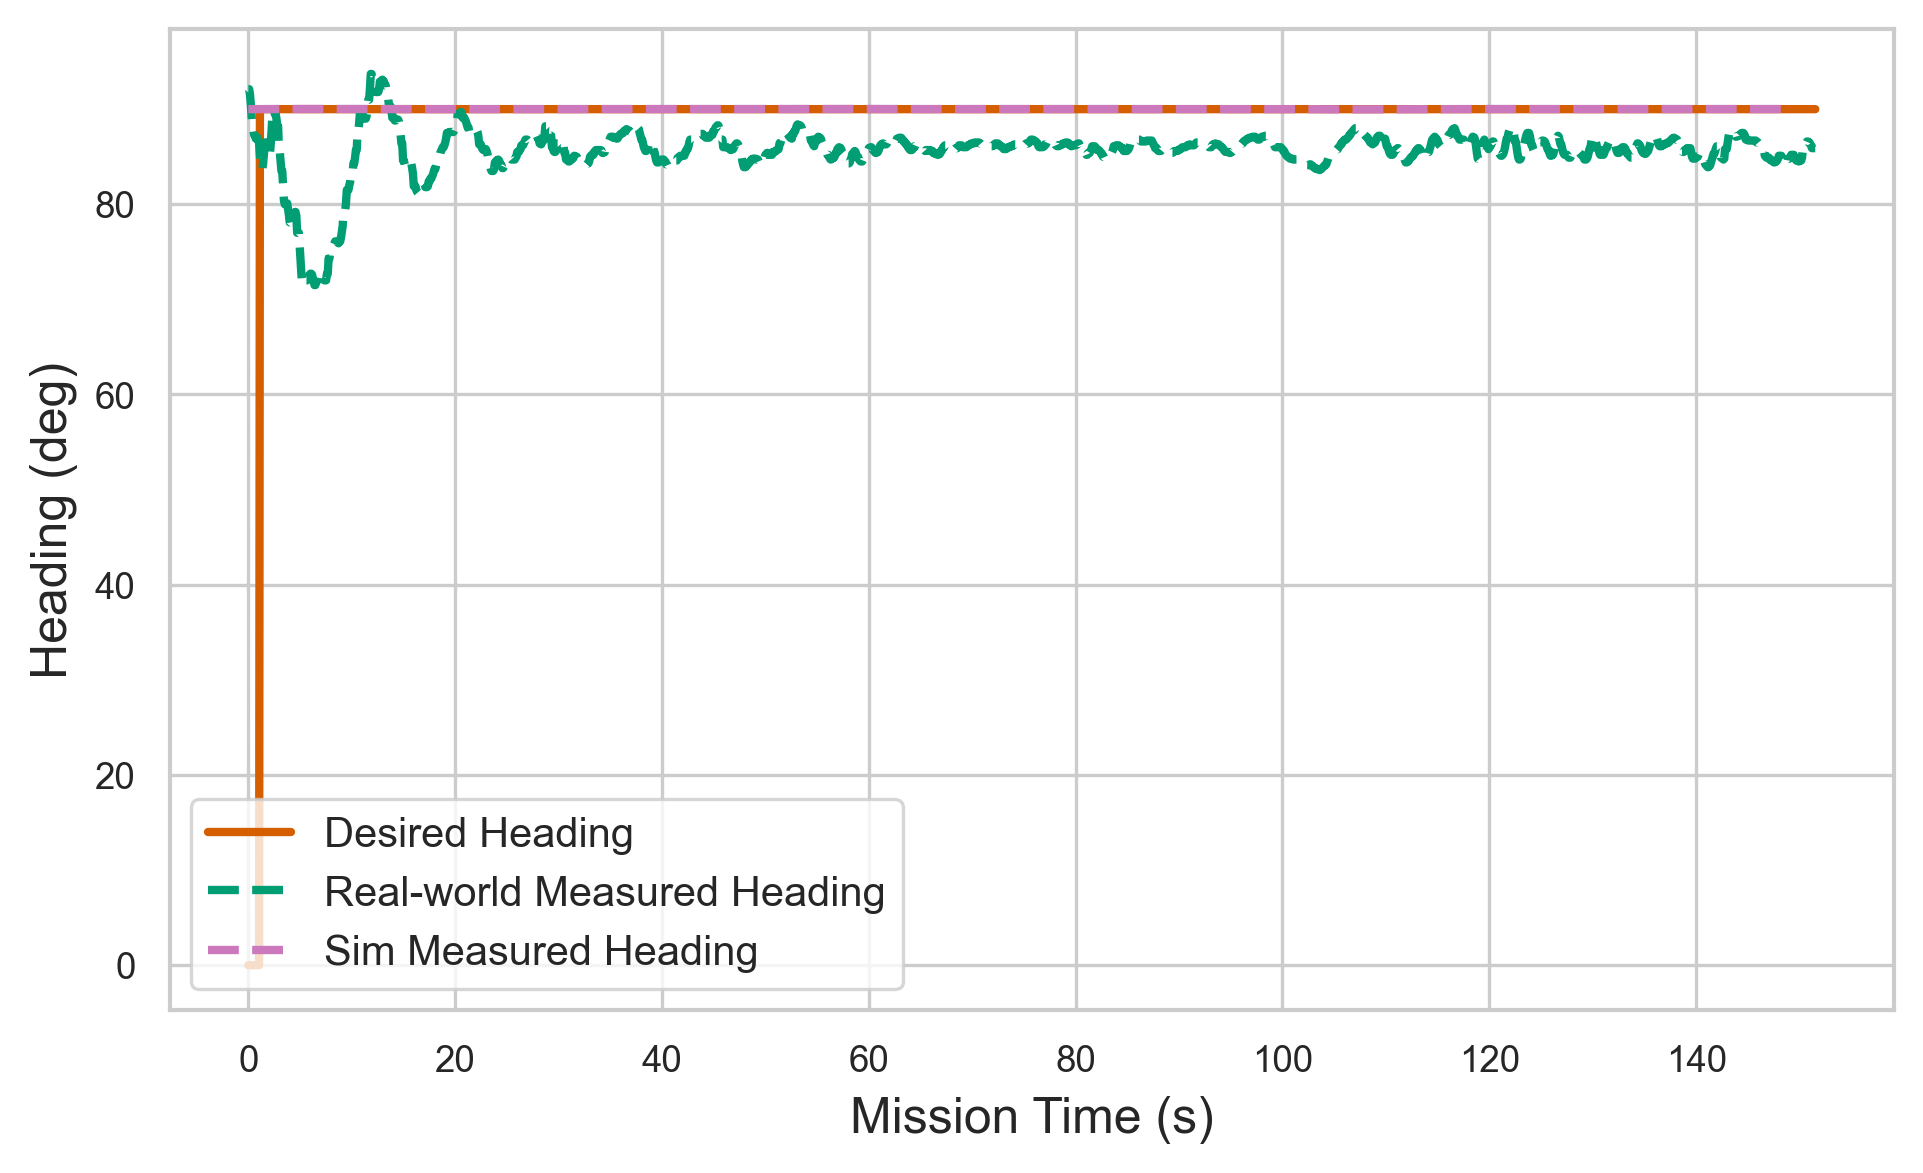

In [21]:

rw_controls_debug = rw_topics["/controls/debug"]
cropped_rw_df = rw_controls_debug.iloc[start_crop:end_crop]

sim_controls_debug = sim_topics["/controls/debug"]
cropped_sim_df = sim_controls_debug.iloc[sim_crop:end_crop_sim]

# Convert timestamp to seconds since mission start
start_time = cropped_rw_df["timestamp"].iloc[0]
cropped_rw_df["time_sec"] = (cropped_rw_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_rw_df["time_sec"].to_numpy()
y1 = cropped_rw_df["heading.desired"].to_numpy()
y2 = cropped_rw_df["heading.actual"].to_numpy()

# Print number of sample in cropped sim dataframe
print(f"Number of samples in cropped sim dataframe: {len(rw_controls_debug)}")

start_time = cropped_sim_df["timestamp"].iloc[0]
cropped_sim_df["time_sec"] = (cropped_sim_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x_sim = cropped_sim_df["time_sec"].to_numpy()
y_sim1 = cropped_sim_df["heading.desired"].to_numpy()
y_sim2 = cropped_sim_df["heading.actual"].to_numpy()

# Apply PDF font embedding and font settings for high-quality vector text in PDF
matplotlib.rc("pdf", fonttype=42)

# Seaborn styles for paper-quality plots
sns.set_context("paper")       # scales fonts nicely for paper
sns.set_style("whitegrid")     # white grid background
sns.set_palette("colorblind")  # colorblind-friendly palette
c = sns.color_palette("colorblind")  # get colorblind palette colors

# Set Times New Roman font and math font style for publication
# plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

# Create figure with high DPI for sharp output
fig, ax = plt.subplots(figsize=(6.5, 4), dpi=300)

ax.plot(x, y1, label='Desired Heading', color=c[3], linewidth=2)
ax.plot(x, y2, label='Real-world Measured Heading', color=c[2], linewidth=2, linestyle='--')

ax.plot(x_sim, y_sim2, label='Sim Measured Heading', color=c[4], linewidth=2, linestyle='--')
# ax.plot(x_sim, y_sim1, label='Sim Desired Depth', color='red', linewidth=2, linestyle='--')

# Labels and formatting
# ax.set_title('Heading Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Heading (deg)', fontsize=12)
# ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower left', fontsize=10)

plt.tight_layout()
# Save figure as PDF with embedded fonts and tight layout
fig.savefig("heading_controls_comparison.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [22]:
import re
def extract_key_values_regex(status_str):
    try:
        keyvals = {}

        # Regex pattern to extract key-value pairs
        pattern = r"key='([^']*)', value='([^']*)'"
        matches = re.findall(pattern, status_str)

        # Additional context to identify the group like CPU or RAM
        hardware_match = re.search(r"hardware_id='([^']*)'", status_str)
        name_match = re.search(r"name='([^']*)'", status_str)

        hardware_id = hardware_match.group(1) if hardware_match else "unknown"
        name = name_match.group(1).replace(":", "").replace(" ", "_") if name_match else "unknown"

        for key, value in matches:
            full_key = f"{hardware_id}/{name}/{key}"
            try:
                value = float(value)
            except ValueError:
                value = None
            keyvals[full_key] = value

        return keyvals
    except Exception as e:
        return {}
    
def find_matching_key(columns, partial_key):
    for col in columns:
        if partial_key.lower() in col.lower():
            # print(f"Found match for '{partial_key}': '{col}'")
            return col
    raise KeyError(f"No match found for: {partial_key}")



# compare the diagnostics CPU and RAM usage from real world and sim
rw_diagnostics = rw_topics["/diagnostics"]
# cropped_rw_df = rw_controls_debug.iloc[start_crop:end_crop]

sim_diagnostics = sim_topics["/diagnostics"]
# cropped_sim_df = sim_diagnostics.iloc[sim_crop:end_crop_sim]

# Apply and normalize the extracted values
rw_extracted = rw_diagnostics["status"].apply(extract_key_values_regex)
rw_diagnostics_expanded = pd.json_normalize(rw_extracted)

sim_extracted = sim_diagnostics["status"].apply(extract_key_values_regex)
sim_diagnostics_expanded = pd.json_normalize(sim_extracted)

# print(rw_diagnostics_expanded.columns.tolist())
# print(rw_extracted.iloc[0])

cpu_key_rw = find_matching_key(rw_diagnostics_expanded.columns, "CPU Load Average")
ram_key_rw = find_matching_key(rw_diagnostics_expanded.columns, "RAM Load Average")

cpu_key_sim = find_matching_key(sim_diagnostics_expanded.columns, "CPU Load Average")
ram_key_sim = find_matching_key(sim_diagnostics_expanded.columns, "RAM Load Average")

avg_cpu_usage = rw_diagnostics_expanded[cpu_key_rw].mean()
avg_ram_usage = rw_diagnostics_expanded[ram_key_rw].mean()

avg_cpu_usage_sim = sim_diagnostics_expanded[cpu_key_sim].mean()
avg_ram_usage_sim = sim_diagnostics_expanded[ram_key_sim].mean()

print(f"Average CPU Usage (Real World): {avg_cpu_usage}")
print(f"Average RAM Usage (Real World): {avg_ram_usage}")
print(f"Average CPU Usage (Simulation): {avg_cpu_usage_sim}")
print(f"Average RAM Usage (Simulation): {avg_ram_usage_sim}")

Average CPU Usage (Real World): 26.954897959183675
Average RAM Usage (Real World): 9.403846153846155
Average CPU Usage (Simulation): 27.16608187134503
Average RAM Usage (Simulation): 8.114035087719298
